## Average time to 1% - Trip Summary

In [1]:
import os, re, sys, utilities
spark_home = os.environ.get('SPARK_HOME', None)

In [2]:
code = utilities.getSparkContext()
exec(code)

KeyboardInterrupt: 

In [ ]:
from pyspark_llap.sql.session import HiveWarehouseSession
from pyspark.sql import SparkSession

#spark = SparkSession.builder.appName("LLAP_Test").enableHiveSupport().config("spark.sql.hive.llap", "true").getOrCreate()
spark = SparkSession.builder.appName("Hive_ACID_warehouseconnector").enableHiveSupport().getOrCreate()
hive = HiveWarehouseSession.session(spark).build()

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
import time
#import datetime
import math
import scipy

In [ ]:
from pyspark.sql.functions import col, udf, countDistinct, isnan, when, count, to_date, from_unixtime, unix_timestamp, min, max, row_number
from pyspark.sql.window import Window
from pyspark.sql.types import Row
from pyspark.sql.functions import year, month, dayofmonth, hour

In [ ]:
from pyspark.sql.types import DoubleType, FloatType, BooleanType, LongType, \
IntegerType, TimestampType, StringType, StructType, StructField, ArrayType

In [ ]:
from pyspark.sql.functions import lit

In [ ]:
import matplotlib.dates as mdates

### Read trip summary data

In [ ]:
# get table with time that 100% id first seen for each oil life cycle for each VIN

In [ ]:
#TODAY = datetime.datetime.strptime('2020-04-08', '%Y-%m-%d')
TODAY = datetime.datetime.today()

In [ ]:
#changed start date to be YTD - Jan 01 2020
START_DATE_1 = "2020-01-01"
END_DATE_1 = (TODAY- datetime.timedelta(days=1)).strftime("%Y-%m-%d")
START_DATE_2 = (TODAY- datetime.timedelta(days=7)).strftime("%Y-%m-%d")
END_DATE_2 = (TODAY- datetime.timedelta(days=1)).strftime("%Y-%m-%d")
START_DATE_3 = (TODAY- datetime.timedelta(days=30)).strftime("%Y-%m-%d")
END_DATE_3 = (TODAY- datetime.timedelta(days=1)).strftime("%Y-%m-%d")

In [ ]:
#df = hive.executeQuery("select * from sakula5_test.hello_acid")
#df.show()

trip_sum_allData = hive.executeQuery("""SELECT T1.cvdcqa_vin_d_3,
coalesce(T1.cvdcqa_oil_chng_cyc_no_r_3,0) as oil_cycle_no,
T1.cvdcqa_trip_no_r_3,
T1.cvdcqa_trip_end_time_s_3,
T1.cvdcqa_trip_end_eng_oil_p_3,
T1.cvdcqa_trip_end_odo_read_r_3,
T1.cvdcqa_partition_date,
T1.cvdcqa_partition_cntry_x
FROM cvdp.NCVDVAJ_TRIP_SUM_SEC_NA_USA_CAT1_VW T1
WHERE T1.cvdcqa_trip_no_r_3 IS NOT NULL AND
T1.cvdcqa_trip_end_time_s_3 IS NOT NULL AND
T1.cvdcqa_trip_end_eng_oil_p_3 IS NOT NULL AND
T1.cvdcqa_trip_end_odo_read_r_3 IS NOT NULL AND
T1.cvdcqa_vin_d_3 IS NOT NULL AND
T1.cvdcqa_partition_cntry_x = 'USA' AND 
year(T1.cvdcqa_trip_end_time_s_3) > 2015""")
# """

In [9]:
#query with odo info - need to drop duplicates after to only get first 100% time
oil_at_100 = hive.executeQuery('''
    SELECT vin,  MIN(trip_end_date) as first_100_time, oil_cycle_num, oil_pct, odo
    FROM (
        SELECT cvdcqa_vin_d_3 as vin,
        coalesce(cvdcqa_oil_chng_cyc_no_r_3,0) as oil_cycle_num,
        to_date(cvdcqa_trip_end_time_s_3) as trip_end_date,
        cvdcqa_trip_end_eng_oil_p_3 as oil_pct,
        cvdcqa_trip_end_odo_read_r_3 as odo
        FROM cvdp.NCVDVAJ_TRIP_SUM_SEC_NA_USA_CAT1_VW
        WHERE cvdcqa_trip_end_time_s_3 IS NOT NULL AND
        cvdcqa_trip_end_eng_oil_p_3 IS NOT NULL AND
        cvdcqa_trip_end_odo_read_r_3 IS NOT NULL AND
        cvdcqa_vin_d_3 IS NOT NULL AND
        cvdcqa_partition_cntry_x = 'USA' AND 
        cvdcqa_trip_end_eng_oil_p_3 = 100
        ) inside
    GROUP BY vin, oil_cycle_num, oil_pct, odo
    ORDER BY vin, oil_cycle_num ASC
    ''')

In [10]:
oil_at_100.show(10)

+-----------------+--------------+-------------+-------+-----+
|              vin|first_100_time|oil_cycle_num|oil_pct|  odo|
+-----------------+--------------+-------------+-------+-----+
|1FA6P8CF0J5100047|    2017-07-19|            0|  100.0|    0|
|1FA6P8CF0J5100159|    2019-01-12|            1|  100.0|18926|
|1FA6P8CF0J5100159|    2019-01-12|            1|  100.0|18932|
|1FA6P8CF0J5100159|    2019-01-12|            1|  100.0|18991|
|1FA6P8CF0J5100159|    2019-01-12|            1|  100.0|18933|
|1FA6P8CF0J5100159|    2019-07-22|            2|  100.0|32743|
|1FA6P8CF0J5100159|    2019-07-22|            2|  100.0|32733|
|1FA6P8CF0J5100159|    2020-07-19|            2|  100.0|44575|
|1FA6P8CF0J5100159|    2020-07-19|            2|  100.0|44554|
|1FA6P8CF0J5100159|    2019-07-24|            2|  100.0|32777|
+-----------------+--------------+-------------+-------+-----+
only showing top 10 rows



In [10]:
# this query does not contain odo information - no need to drop duplicates
oil_at_100 = hive.executeQuery('''
    SELECT vin,  MIN(trip_end_date) as first_100_time, oil_cycle_num, oil_pct
    FROM (
        SELECT cvdcqa_vin_d_3 as vin,
        coalesce(cvdcqa_oil_chng_cyc_no_r_3,0) as oil_cycle_num,
        to_date(cvdcqa_trip_end_time_s_3) as trip_end_date,
        cvdcqa_trip_end_eng_oil_p_3 as oil_pct
        FROM cvdp.NCVDVAJ_TRIP_SUM_SEC_NA_USA_CAT1_VW
        WHERE cvdcqa_trip_end_time_s_3 IS NOT NULL AND
        cvdcqa_trip_end_eng_oil_p_3 IS NOT NULL AND
        cvdcqa_trip_end_odo_read_r_3 IS NOT NULL AND
        cvdcqa_vin_d_3 IS NOT NULL AND
        cvdcqa_partition_cntry_x = 'USA' AND 
        cvdcqa_trip_end_eng_oil_p_3 = 100
        ) inside
    GROUP BY vin, oil_cycle_num, oil_pct
    ORDER BY vin, oil_cycle_num ASC
    ''')

In [11]:
# drop duplicates - use with query including odo 
oil_at_100 = oil_at_100.dropDuplicates(['vin', 'first_100_time', 'oil_cycle_num'])
oil_at_100.show(10)

+-----------------+--------------+-------------+-------+-----+
|              vin|first_100_time|oil_cycle_num|oil_pct|  odo|
+-----------------+--------------+-------------+-------+-----+
|1FA6P8CF0J5100484|    2018-02-04|            0|  100.0|  359|
|1FA6P8CF0J5107600|    2018-01-24|            0|  100.0|  478|
|1FA6P8CF0J5121058|    2019-05-05|            0|  100.0|32167|
|1FA6P8CF0J5127099|    2018-01-21|            0|  100.0|  262|
|1FA6P8CF0J5127331|    2018-02-07|            0|  100.0|  242|
|1FA6P8CF0J5127586|    2018-04-19|            0|  100.0|   84|
|1FA6P8CF0J5129175|    2018-02-06|            0|  100.0|  439|
|1FA6P8CF0J5135140|    2018-02-20|            0|  100.0|  499|
|1FA6P8CF0J5154352|    2018-05-01|            0|  100.0|  535|
|1FA6P8CF0J5154660|    2018-05-03|            0|  100.0|  437|
+-----------------+--------------+-------------+-------+-----+
only showing top 10 rows



In [11]:
oil_at_100.show(10)

+-----------------+--------------+-------------+-------+
|              vin|first_100_time|oil_cycle_num|oil_pct|
+-----------------+--------------+-------------+-------+
|1FA6P8CF0J5100047|    2017-07-19|            0|  100.0|
|1FA6P8CF0J5100159|    2019-01-12|            1|  100.0|
|1FA6P8CF0J5100159|    2019-07-22|            2|  100.0|
|1FA6P8CF0J5100162|    2017-10-11|            0|  100.0|
|1FA6P8CF0J5100310|    2019-07-16|            0|  100.0|
|1FA6P8CF0J5100419|    2019-09-18|            0|  100.0|
|1FA6P8CF0J5100467|    2018-02-01|            0|  100.0|
|1FA6P8CF0J5100484|    2018-02-01|            0|  100.0|
|1FA6P8CF0J5100484|    2018-11-29|            1|  100.0|
|1FA6P8CF0J5100713|    2018-08-11|            0|  100.0|
+-----------------+--------------+-------------+-------+
only showing top 10 rows



In [57]:
#check for one VIN
oil_at_100.filter(oil_at_100["vin"] == 'NM0LS7E2XK1407327').show()

+-----------------+--------------+-------------+-------+
|              vin|first_100_time|oil_cycle_num|oil_pct|
+-----------------+--------------+-------------+-------+
|NM0LS7E2XK1407327|    2019-07-10|            0|  100.0|
|NM0LS7E2XK1407327|    2019-09-20|            1|  100.0|
+-----------------+--------------+-------------+-------+



In [ ]:
# get table with first date at 1% oil life for each VIN and oil life cycle

In [ ]:
#query with odo info - need to drop duplicates after to only get first 100% time
oil_at_1pct = hive.executeQuery('''
    SELECT vin,  MIN(trip_end_date) as first_1pct_time, oil_cycle_num, oil_pct, odo
    FROM (
        SELECT cvdcqa_vin_d_3 as vin,
        coalesce(cvdcqa_oil_chng_cyc_no_r_3,0) as oil_cycle_num,
        to_date(cvdcqa_trip_end_time_s_3) as trip_end_date,
        cvdcqa_trip_end_eng_oil_p_3 as oil_pct,
        cvdcqa_trip_end_odo_read_r_3 as odo
        FROM cvdp.NCVDVAJ_TRIP_SUM_SEC_NA_USA_CAT1_VW
        WHERE cvdcqa_trip_end_time_s_3 IS NOT NULL AND
        cvdcqa_trip_end_eng_oil_p_3 IS NOT NULL AND
        cvdcqa_trip_end_odo_read_r_3 IS NOT NULL AND
        cvdcqa_vin_d_3 IS NOT NULL AND
        cvdcqa_partition_cntry_x = 'USA' AND 
        cvdcqa_trip_end_eng_oil_p_3 = 1
        ) inside
    GROUP BY vin, oil_cycle_num, oil_pct, odo
    ORDER BY vin, oil_cycle_num ASC
    ''')

In [12]:
# query without odo info
oil_at_1pct = hive.executeQuery('''
    SELECT vin,  MIN(trip_end_date) as first_1pct_time, oil_cycle_num, oil_pct_end
    FROM (
        SELECT cvdcqa_vin_d_3 as vin,
        coalesce(cvdcqa_oil_chng_cyc_no_r_3,0) as oil_cycle_num,
        to_date(cvdcqa_trip_end_time_s_3) as trip_end_date,
        cvdcqa_trip_end_eng_oil_p_3 as oil_pct_end
        FROM cvdp.NCVDVAJ_TRIP_SUM_SEC_NA_USA_CAT1_VW
        WHERE cvdcqa_trip_end_time_s_3 IS NOT NULL AND
        cvdcqa_trip_end_eng_oil_p_3 IS NOT NULL AND
        cvdcqa_trip_end_odo_read_r_3 IS NOT NULL AND
        cvdcqa_vin_d_3 IS NOT NULL AND
        cvdcqa_partition_cntry_x = 'USA' AND 
        cvdcqa_trip_end_eng_oil_p_3 = 1
        ) inside
    GROUP BY vin, oil_cycle_num, oil_pct_end
    ORDER BY vin, oil_cycle_num ASC
    ''')

In [13]:
oil_at_1pct = oil_at_1pct.dropDuplicates(['vin', 'first_1pct_time', 'oil_cycle_num'])

In [13]:
oil_at_1pct.show(10)

+-----------------+---------------+-------------+-----------+
|              vin|first_1pct_time|oil_cycle_num|oil_pct_end|
+-----------------+---------------+-------------+-----------+
|1FA6P8CF0J5100159|     2018-12-01|            0|        1.0|
|1FA6P8CF0J5100159|     2020-06-14|            2|        1.0|
|1FA6P8CF0J5100310|     2020-07-11|            0|        1.0|
|1FA6P8CF0J5101358|     2018-08-10|            0|        1.0|
|1FA6P8CF0J5101571|     2019-04-29|            0|        1.0|
|1FA6P8CF0J5102669|     2019-06-24|            0|        1.0|
|1FA6P8CF0J5102848|     2020-06-26|            0|        1.0|
|1FA6P8CF0J5103417|     2019-11-17|            2|        1.0|
|1FA6P8CF0J5103417|     2020-06-12|            3|        1.0|
|1FA6P8CF0J5104292|     2019-06-09|            0|        1.0|
+-----------------+---------------+-------------+-----------+
only showing top 10 rows



In [56]:
#Check for 1 VIN
oil_at_1pct.filter(oil_at_1pct["vin"] == 'NM0LS7E2XK1407327').show()

+-----------------+---------------+-------------+-----------+
|              vin|first_1pct_time|oil_cycle_num|oil_pct_end|
+-----------------+---------------+-------------+-----------+
|NM0LS7E2XK1407327|     2019-05-06|            0|        1.0|
|NM0LS7E2XK1407327|     2019-11-26|            1|        1.0|
+-----------------+---------------+-------------+-----------+



### Join tables to get both dates and calculate average time to 1%

In [15]:
# Full History DF
df_o = oil_at_100.join(oil_at_1pct, on=['vin','oil_cycle_num'], how='inner')
df_o.show(5)

+-----------------+-------------+--------------+-------+---------------+-----------+
|              vin|oil_cycle_num|first_100_time|oil_pct|first_1pct_time|oil_pct_end|
+-----------------+-------------+--------------+-------+---------------+-----------+
|1FA6P8CF1J5180202|            0|    2018-11-24|  100.0|     2019-08-23|        1.0|
|1FA6P8CF1K5189547|            0|    2019-08-07|  100.0|     2019-11-11|        1.0|
|1FA6P8CF4K5111831|            0|    2019-02-23|  100.0|     2020-02-25|        1.0|
|1FA6P8CF4K5141685|            1|    2019-11-16|  100.0|     2020-06-28|        1.0|
|1FA6P8CF4K5147910|            0|    2019-03-20|  100.0|     2019-12-08|        1.0|
+-----------------+-------------+--------------+-------+---------------+-----------+
only showing top 5 rows



In [16]:
# convert to pandas
oil_100to1 = df_o.toPandas()

In [17]:
# calculate difference between the dates to get time to 1% for each VIN and oil life cycle

# timedelta subtraction needed here
#df_test['Difference'] = (df_test['First_Date'] - df_test['Second Date']).dt.days
oil_100to1["delta_time"] = (oil_100to1['first_1pct_time'] - oil_100to1['first_100_time']).dt.days

In [18]:
oil_100to1

vin  oil_cycle_num first_100_time  oil_pct  \
0       1FA6P8CF1J5180202              0     2018-11-24    100.0   
1       1FA6P8CF1K5189547              0     2019-08-07    100.0   
2       1FA6P8CF4K5111831              0     2019-02-23    100.0   
3       1FA6P8CF4K5141685              1     2019-11-16    100.0   
4       1FA6P8CF4K5147910              0     2019-03-20    100.0   
...                   ...            ...            ...      ...   
574612  NM0LS7E2XK1407327              0     2019-07-10    100.0   
574613  NM0LS7F20K1408596              0     2019-05-30    100.0   
574614  NM0LS7F24K1413557              1     2020-03-03    100.0   
574615  NM0LS7F25K1408335              0     2019-11-25    100.0   
574616  NM0LS7F26K1415648              0     2019-06-11    100.0   

       first_1pct_time  oil_pct_end  delta_time  
0           2019-08-23          1.0         272  
1           2019-11-11          1.0          96  
2           2020-02-25          1.0         367  
3           2020-06-28          1.0         225  
4           2019-12-08          1.0         263  
...                ...          ...         ...  
574612      2019-05-06          1.0         -65  
574613      2019-09-03          1.0          96  
574614      2020-07-13          1.0         132  
574615      2020-06-06          1.0         194  
574616      2020-01-22          1.0         225  

[574617 rows x 7 columns]

In [41]:
#check for one vin - timestamp issue?
oil_100to1[oil_100to1['vin'] == 'NM0LS7E2XK1407327']

vin  oil_cycle_num first_100_time  oil_pct  \
391336  NM0LS7E2XK1407327              1     2019-09-20    100.0   
574612  NM0LS7E2XK1407327              0     2019-07-10    100.0   

       first_1pct_time  oil_pct_end  delta_time  
391336      2019-11-26          1.0          67  
574612      2019-05-06          1.0         -65

In [40]:
oil_100to1["delta_time"].count()

574617

In [ ]:
# Data Quality issues? negative 100-1% times?

In [25]:
oil_100to1[(oil_100to1['delta_time']<0)]['delta_time'].count()

67250

In [32]:
oil_100to1[(oil_100to1['delta_time']<0)]['delta_time'].count()

4089

In [48]:
oil_100to1[(oil_100to1['delta_time']>30)]['delta_time'].count()

502651

In [26]:
# Percent of invailid data points
67250/574617

0.11703447687764197

In [44]:
# filter those out
oil_filtered = oil_100to1[(oil_100to1['delta_time']>0)]

In [75]:
oil_filtered["delta_time"].count()

503278

In [45]:
# Avg time to 1pct
oil_filtered["delta_time"].describe()
#oil_100to1["delta_time"].mean()

count    503278.000000
mean        254.514125
std         141.685314
min           1.000000
25%         151.000000
50%         225.000000
75%         359.000000
max        1494.000000
Name: delta_time, dtype: float64

In [46]:
# investigate super low time deltas --> is there a min days threshold for oil life degredation to 1%?

### Plot

Text(0.5, 1.0, 'Time to 1% Oil Life per VIN per oil life cycle number')

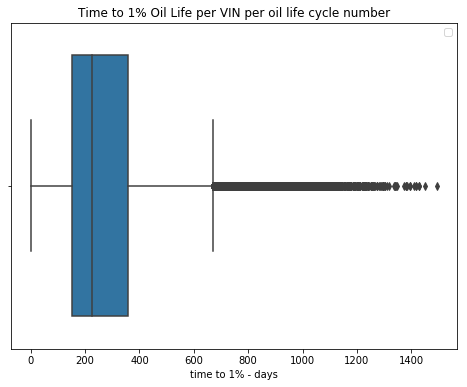

In [82]:
# boxplot - times to 1% 
size  = (8, 6)
fig, ax = plt.subplots(figsize = size)

ax = sns.boxplot(x=oil_filtered["delta_time"])

# Plot formatting
plt.xlabel('time to 1% - days')
plt.legend()
plt.title('Time to 1% Oil Life per VIN per oil life cycle number')

/u/lguerra5/.conda/envs/py368nb/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Distribution of Time to 1% Oil Life per VIN per oil life cycle number')

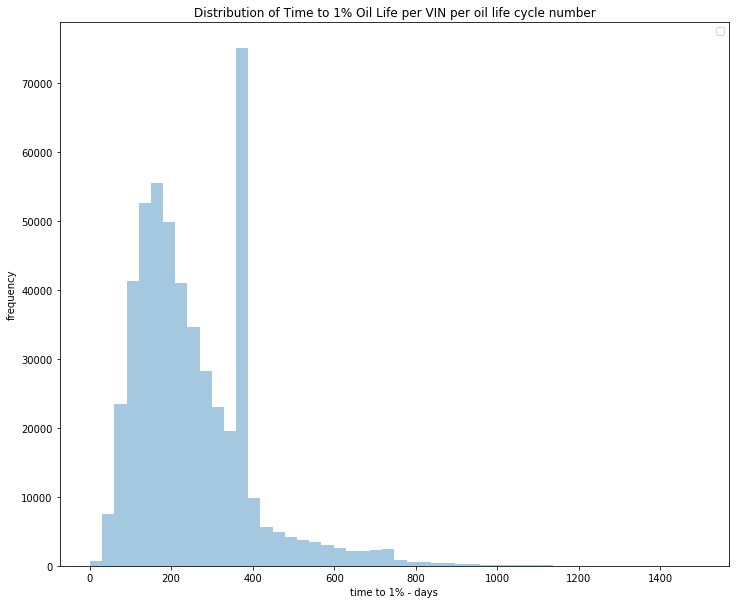

In [77]:
size  = (12, 10)
fig, ax = plt.subplots(figsize = size)
sns.distplot( oil_filtered["delta_time"], kde = False)

# Plot formatting
plt.xlabel('time to 1% - days')
plt.ylabel('frequency')
plt.legend()
plt.title('Distribution of Time to 1% Oil Life per VIN per oil life cycle number')

### Use pre-processing to check results - maybe less noise?

In [52]:
df = spark.read.parquet('hdfs://hdp2cluster/user/lguerra5/pae_processing_prod/trip_summary_preprocessed_subset_full/*')

In [53]:
df.show(10)

+------------------------+-----------------+-----------------+-------------+-----------+---------------+-----------------------+------------+--------------+-------------+
|trip_end_eng_oil_percent|trip_end_odo_read|              vin|trip_end_date|trip_number|oil_change_flag|oil_change_cycle_number|first_ol_pct|first_odometer|first_ol_date|
+------------------------+-----------------+-----------------+-------------+-----------+---------------+-----------------------+------------+--------------+-------------+
|                    80.0|            41359|1FA6P8CF8J5125374|   2019-07-28|       2177|              0|                      7|       100.0|         65387|   2020-05-09|
|                    80.0|            41368|1FA6P8CF8J5125374|   2019-07-29|       2178|              0|                      7|       100.0|         65387|   2020-05-09|
|                    80.0|            41370|1FA6P8CF8J5125374|   2019-07-29|       2179|              0|                      7|       100.0|    

In [65]:
#oil_at_1pct[oil_at_1pct['vin'] == 'NM0LS7E2XK1407327'].show()
new_df = df.filter(df["trip_end_eng_oil_percent"] == 1)

In [66]:
new_df = new_df.filter(df["first_ol_pct"] >= 99)

In [67]:
new_df = new_df.dropDuplicates(['vin','oil_change_cycle_number'])

In [68]:
new_df.show(10)

+------------------------+-----------------+-----------------+-------------+-----------+---------------+-----------------------+------------+--------------+-------------+
|trip_end_eng_oil_percent|trip_end_odo_read|              vin|trip_end_date|trip_number|oil_change_flag|oil_change_cycle_number|first_ol_pct|first_odometer|first_ol_date|
+------------------------+-----------------+-----------------+-------------+-----------+---------------+-----------------------+------------+--------------+-------------+
|                     1.0|            87971|1FMCU9J96HUA32213|   2019-04-12|       2073|              0|                      3|       100.0|        128479|   2020-03-21|
|                     1.0|            48844|1FMCU9JD4HUC51921|   2019-03-20|       1691|              0|                      1|       100.0|         66510|   2020-01-06|
|                     1.0|            98785|1FTEW1EG1HFC59234|   2019-07-17|       1718|              0|                      4|       100.0|    

In [69]:
prep_df = new_df.toPandas()

In [71]:
# calculate difference between the dates to get time to 1% for each VIN and oil life cycle
prep_df["delta_time"] = (prep_df['trip_end_date'] - prep_df['first_ol_date']).dt.days

In [72]:
prep_df

trip_end_eng_oil_percent  trip_end_odo_read                vin  \
0                          1.0              30511  1FMCU0JD1HUD28336   
1                          1.0              48569  1FMCU9G91HUC66394   
2                          1.0              36901  1FMCU9GD6HUB52752   
3                          1.0              48588  1FTEW1EF4HKD81309   
4                          1.0              45517  1FM5K7F85JGA02174   
...                        ...                ...                ...   
1814                       1.0              32970  1FM5K7D81JGC85143   
1815                       1.0              53970  1FMCU9GD8JUB13179   
1816                       1.0              78772  1FMCU0G95HUB99732   
1817                       1.0              21036  1FT7W2B61KED33677   
1818                       1.0              16348  1FM5K8D82JGC41626   

     trip_end_date  trip_number  oil_change_flag  oil_change_cycle_number  \
0       2019-02-09         1290                0                        1   
1       2019-09-03         3087                0                        3   
2       2018-07-21          601                0                        0   
3       2019-03-23         2517                0                        2   
4       2019-06-30         2379                0                        2   
...            ...          ...              ...                      ...   
1814    2019-08-30         1885                0                        1   
1815    2019-12-04         3289                0                        2   
1816    2019-09-23          154                0                        0   
1817    2019-10-26         1238                0                        1   
1818    2019-07-13          862                0                        0   

      first_ol_pct  first_odometer first_ol_date  delta_time  
0            100.0           47995    2020-01-13        -338  
1            100.0           68263    2020-02-19        -169  
2            100.0           74612    2020-06-05        -685  
3            100.0           81836    2020-06-17        -452  
4            100.0           73707    2020-04-15        -290  
...            ...             ...           ...         ...  
1814         100.0           48743    2020-02-24        -178  
1815         100.0           70005    2020-04-25        -143  
1816         100.0          101097    2020-03-02        -161  
1817         100.0           43056    2020-05-06        -193  
1818         100.0           32112    2020-01-09        -180  

[1819 rows x 11 columns]

In [70]:
prep_df[prep_df['vin'] == 'NM0LS7E2XK1407327']

Empty DataFrame
Columns: [trip_end_eng_oil_percent, trip_end_odo_read, vin, trip_end_date, trip_number, oil_change_flag, oil_change_cycle_number, first_ol_pct, first_odometer, first_ol_date]
Index: []

In [73]:
# Avg time to 1pct
prep_df["delta_time"].describe()
#oil_100to1["delta_time"].mean()

count    1819.000000
mean     -225.041231
std       155.462948
min      -894.000000
25%      -317.000000
50%      -216.000000
75%      -117.500000
max       303.000000
Name: delta_time, dtype: float64

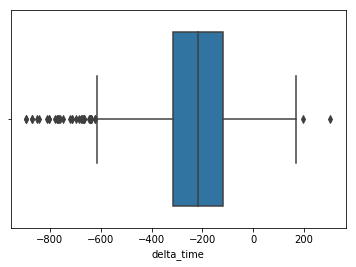

In [83]:
# boxplot - times to 1% 
ax = sns.boxplot(x=prep_df["delta_time"])

/u/lguerra5/.conda/envs/py368nb/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


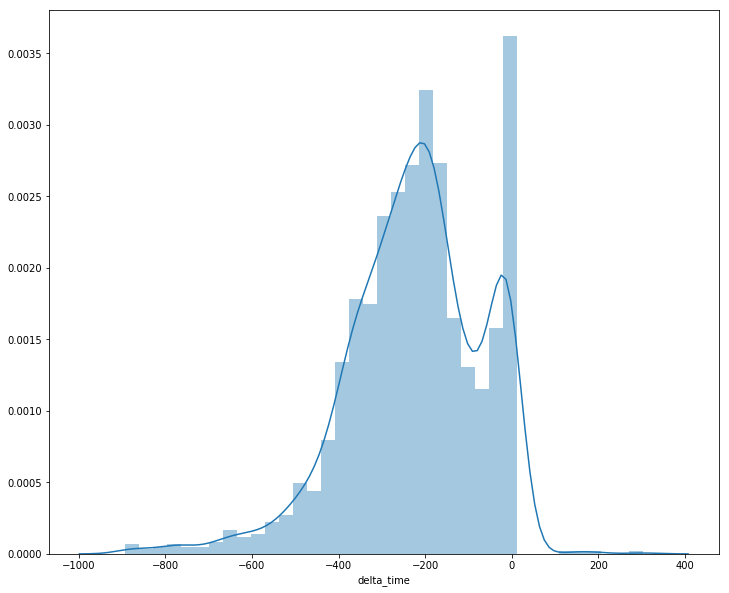

In [84]:
size  = (12, 10)
fig, ax = plt.subplots(figsize = size)
sns.distplot(prep_df["delta_time"])